In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/RATIO15__white_resize96x1440_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

(12, 562, 3)


None
(96, 1440, 3)


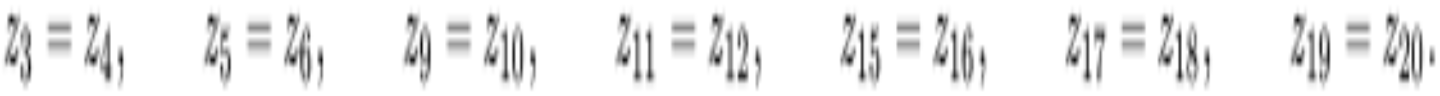

None
torch.Size([1, 96, 1440])


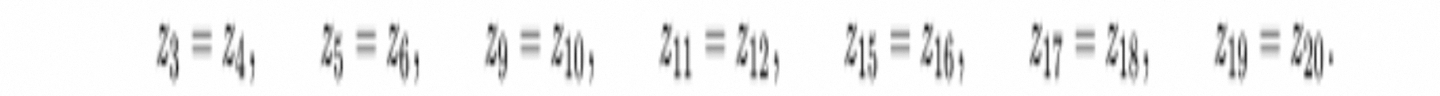

None

Predicted formula:
 <S> z _ { 3 } = z _ { 4 } , \qquad z _ { 5 } = z _ { 6 } , \qquad z _ { 9 } = z _ { 1 0 } , \qquad z _ { 1 1 } = z _ { 1 2 } , \qquad z _ { 1 5 } = z _ { 1 6 } , \qquad z _ { 1 7 } = z _ { 1 8 } , \qquad z _ { 1 9 } = z _ { 2 0 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> z _ { 3 } = z _ { 4 } , \qquad z _ { 5 } = z _ { 6 } , \qquad z _ { 9 } = z _ { 1 0 } , \qquad z _ { 1 1 } = z _ { 1 2 } , \qquad z _ { 1 5 } = z _ { 1 6 } , \qquad z _ { 1 7 } = z _ { 1 8 } , \qquad z _ { 1 9 } = z _ { 2 0 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [8]:
MAX_RATIO = 15

import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

image_path= 'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png'
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(41, 178, 3)


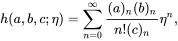

None
(96, 384, 3)


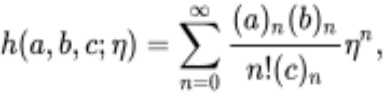

None
torch.Size([1, 96, 384])


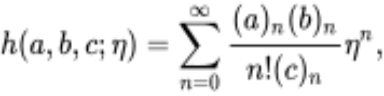

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [9]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(116, 516, 3)


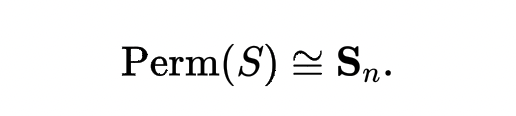

None
(96, 384, 3)


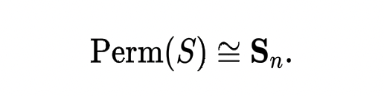

None
torch.Size([1, 96, 384])


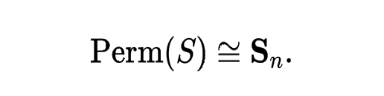

None

Predicted formula:
 <S> { \bf P } \mathrm { e r m } \big ( { \cal S } \big ) \ \cong \ { \bf S } _ { n } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> { \bf P } \mathrm { e r m } \big ( { \cal S } \big ) \ \cong \ { \bf S } _ { n } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [102]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(112, 424, 3)


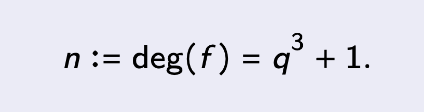

None
ratio 3
(96, 288, 3)


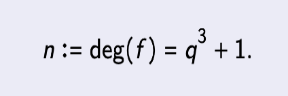

None
torch.Size([1, 96, 288])


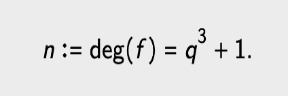

None


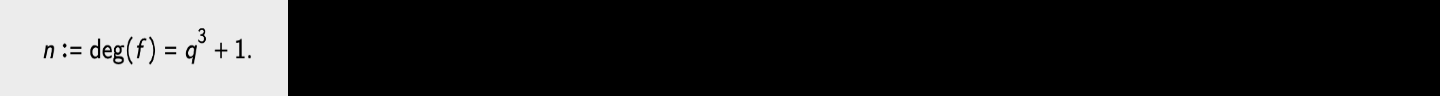

None

Predicted formula:
 <S> { \bf R } : \approx \textbf { G } ^ { 2 } \times 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> { \bf R } : \approx \textbf { G } ^ { 2 } \times 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [97]:
image_path= "Jupyter_Notebooks/test_photos/my_image.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO

print('ratio',ratio)
new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)
print(display(transform(image_tensor)))


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(152, 658, 3)


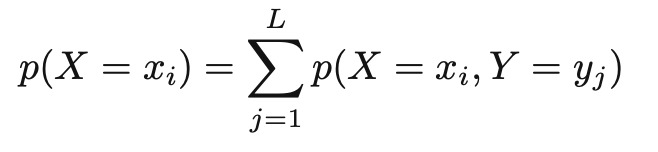

None
(96, 384, 3)


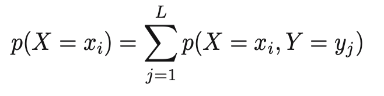

None
torch.Size([1, 96, 384])


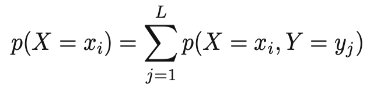

None

Predicted formula:
 <S> p \bigl ( X \, = \, x _ { i } \bigr ) = \sum _ { j = 1 } ^ { L } p \bigl ( X \, = \, x _ { i } , Y \, = \, y _ { j } \bigr ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> p \bigl ( X \, = \, x _ { i } \bigr ) = \sum _ { j = 1 } ^ { L } p \bigl ( X \, = \, x _ { i } , Y \, = \, y _ { j } \bigr ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [75]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(320, 1080, 3)


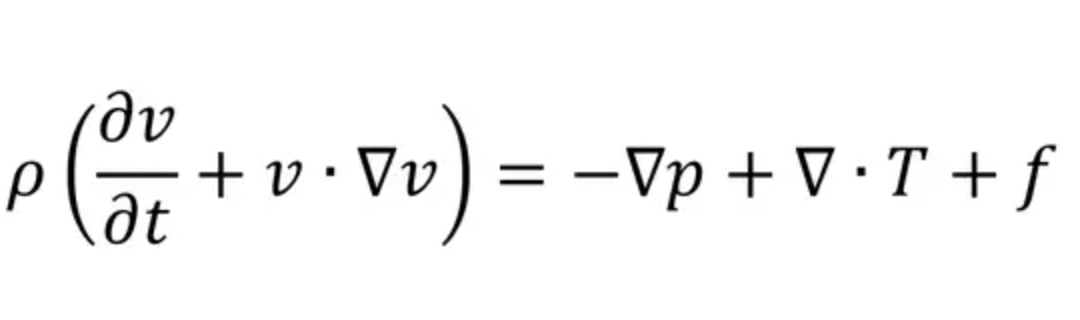

None
(96, 288, 3)


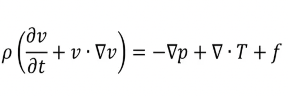

None
torch.Size([1, 96, 288])


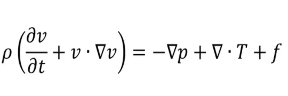

None

Predicted formula:
 <S> \rho \left( \frac { \partial \psi } { \partial t } \downarrow \psi \cdot { \bf Q } _ { \bf p } \right) = - { \bf Q p } + { \bf \nabla } \cdot T \times T \times f . T \times f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> \rho \left( \frac { \partial \psi } { \partial t } \downarrow \psi \cdot { \bf Q } _ { \bf p } \right) = - { \bf Q p } + { \bf \nabla } \cdot T \times T \times f . T \times f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [79]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =w / h
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

#image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(23, 57, 3)


None
(96, 192, 3)


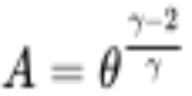

None
torch.Size([1, 96, 192])


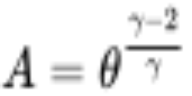

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [80]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

#image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(200, 1424, 3)


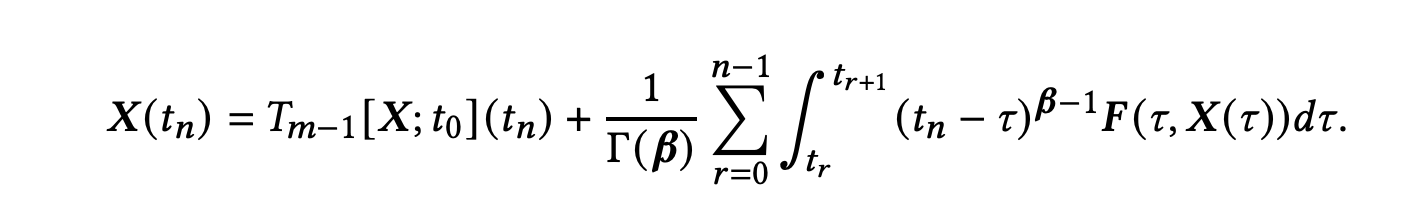

None
(96, 672, 3)


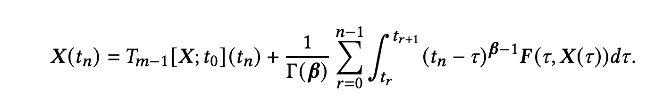

None
torch.Size([1, 96, 672])


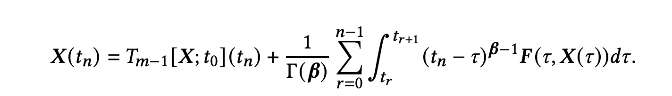

None

Predicted formula:
 <S> { \bf X } ( t { \bf p } ) \in { \bf T } _ { m - 1 } \{ { \cal X } _ { \bf q } \} * \frac { 1 } { \Gamma ( { \bf E } ) } \sum _ { r = 0 } ^ { n - 1 } { \bf I } _ { \bf f } ^ { q - 1 } { \bf I } _ { \bf r } ^ { \bf q } { \bf q } _ { r } } ^ { \bf q - 1 } { \bf F } ( { \bf L } ) } { \bf F } . <E> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> { \bf X } ( t { \bf p } ) \in { \bf T } _ { m - 1 } \{ { \cal X } _ { \bf q } \} * \frac { 1 } { \Gamma ( { \bf E } ) } \sum _ { r = 0 } ^ { n - 1 } { \bf I } _ { \bf f } ^ { q - 1 } { \bf I } _ { \bf r } ^ { \bf q } { \bf q } _ { r } } ^ { \bf q - 1 } { \bf F } ( { \bf L } ) } { \bf F } . <E> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [81]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

#image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(188, 1950, 3)


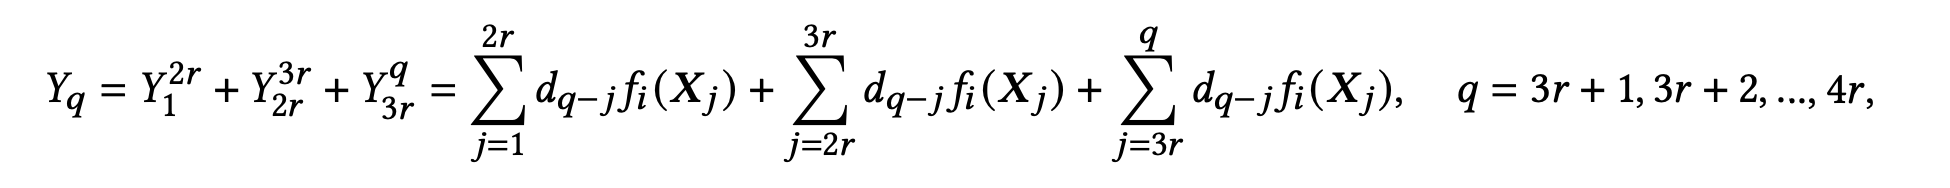

None
(96, 960, 3)


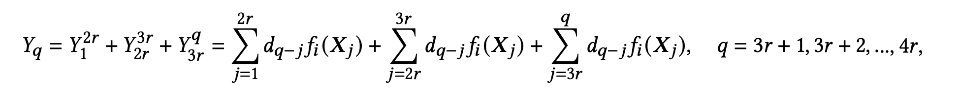

None
torch.Size([1, 96, 960])


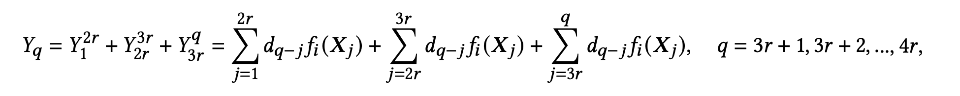

None

Predicted formula:
 <S> { \bf Y } _ { q } \approx Y _ { 1 } ^ { 2 r } * Y _ { Z r } ^ { 2 } \approx \sum _ { j = 1 } ^ { 2 { \cal F } } d _ { q } j f ( { \cal X } _ { j } ) * \sum _ { j \equiv Z r } ^ { 2 { \cal T } } { d _ { q - j f } f ( { \cal X } _ { j } ) * \sum _ { j = g } ^ { 2 } d q - j f f _ { L } ( { \bf X } ) <E>


<IPython.core.display.Math object>

None
 <S> { \bf Y } _ { q } \approx Y _ { 1 } ^ { 2 r } * Y _ { Z r } ^ { 2 } \approx \sum _ { j = 1 } ^ { 2 { \cal F } } d _ { q } j f ( { \cal X } _ { j } ) * \sum _ { j \equiv Z r } ^ { 2 { \cal T } } { d _ { q - j f } f ( { \cal X } _ { j } ) * \sum _ { j = g } ^ { 2 } d q - j f f _ { L } ( { \bf X } ) <E>


<IPython.core.display.Math object>

None


In [82]:
 
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.test_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(202, 1774, 3)


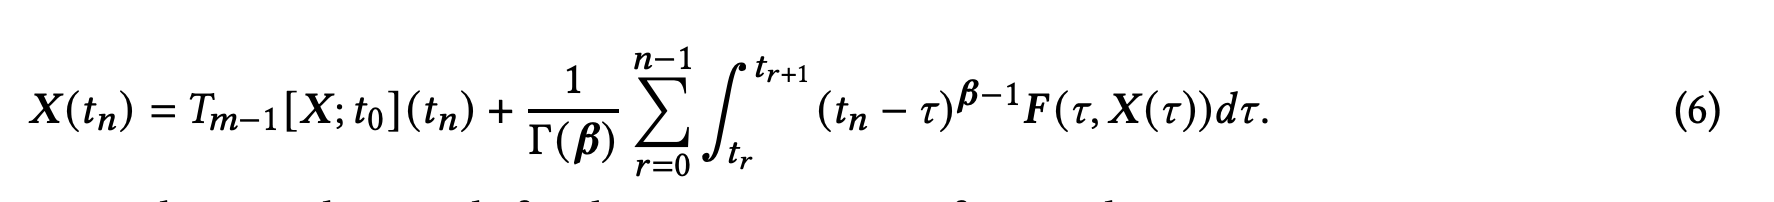

None
(96, 768, 3)


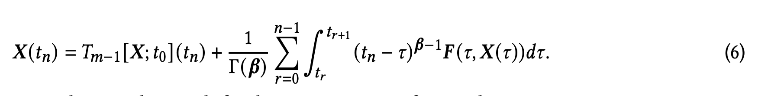

None
torch.Size([1, 96, 768])


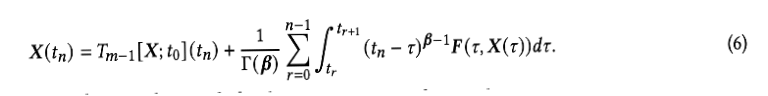

None

Predicted formula:
 <S> { \bf X } ( t _ { \bf p } ) = { \cal I } _ { m - 1 } ( { \bf X } ) ( q ) * \frac { 1 } { \Gamma ( B ) } \sum _ { r = 6 } ^ { q - 1 } \int \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None
 <S> { \bf X } ( t _ { \bf p } ) = { \cal I } _ { m - 1 } ( { \bf X } ) ( q ) * \frac { 1 } { \Gamma ( B ) } \sum _ { r = 6 } ^ { q - 1 } \int \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None


In [17]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(384, 812, 3)


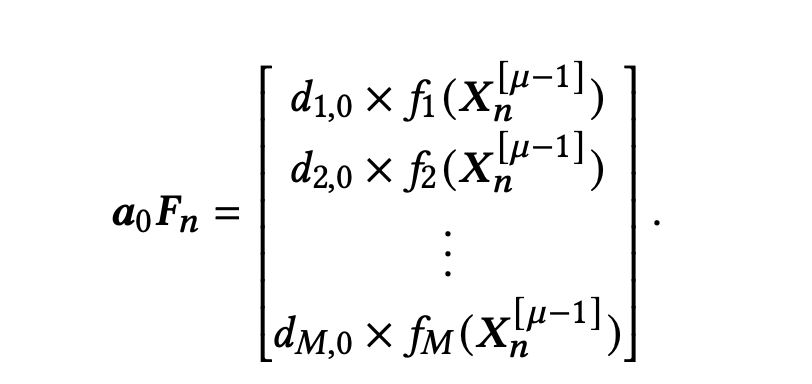

None
(96, 192, 3)


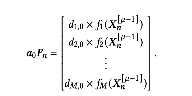

None
torch.Size([1, 96, 192])


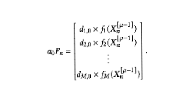

None

Predicted formula:
 <S> { \cal R } = \left[ \begin{array} { c } { 2 \kappa _ { 2 } ( k ) } \\ { 2 \kappa _ { 3 } ( 2 ) } \\ { } & { { } _ { 3 } ( 2 ) } \\ { { A _ { 2 } ( 2 ) } \\ { { } _ { 3 } , { \cal B } ^ { 1 ) } } \\ \end{array} \right] <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> { \cal R } = \left[ \begin{array} { c } { 2 \kappa _ { 2 } ( k ) } \\ { 2 \kappa _ { 3 } ( 2 ) } \\ { } & { { } _ { 3 } ( 2 ) } \\ { { A _ { 2 } ( 2 ) } \\ { { } _ { 3 } , { \cal B } ^ { 1 ) } } \\ \end{array} \right] <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [18]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(224, 1020, 3)


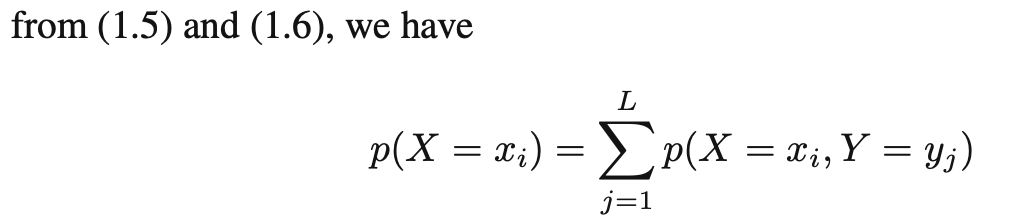

None
(96, 384, 3)


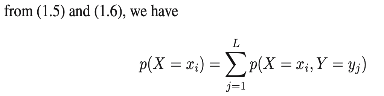

None
torch.Size([1, 96, 384])


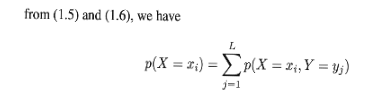

None

Predicted formula:
 <S> \begin{array} { l } { \mathrm { I o n ~ \{ S ) \mathrm { w e h v h v o } } & { } \\ { p ( X = z _ { i j } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> \begin{array} { l } { \mathrm { I o n ~ \{ S ) \mathrm { w e h v h v o } } & { } \\ { p ( X = z _ { i j } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [19]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_2.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(100, 600, 3)


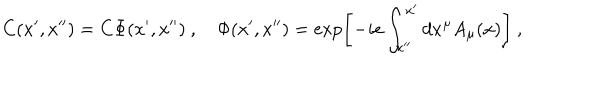

None
(96, 576, 3)


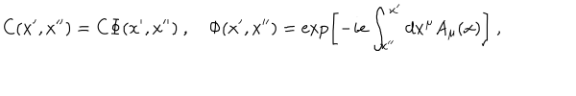

None
torch.Size([1, 96, 576])


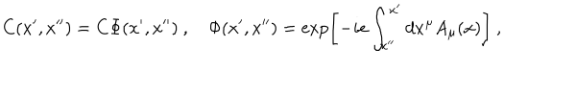

None

Predicted formula:
 <S> \begin{array} { c c c } { C ( { \cal X } ^ { \prime } } \, { \cal P } ^ { \rho } ) = \, \zeta \, \xi \, ( { \pi } ^ { - } { \cal X ^ { \prime } } ^ { \prime } ) \, \, \, \, \, \, \, \, \, \, \, \, \mathrm { \Phi } \left( { \cal N } _ { \prime } ^ { \prime } } \, { \cal L } \, { \bf k } ^ { \prime } } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
 <S> \begin{array} { c c c } { C ( { \cal X } ^ { \prime } } \, { \cal P } ^ { \rho } ) = \, \zeta \, \xi \, ( { \pi } ^ { - } { \cal X ^ { \prime } } ^ { \prime } ) \, \, \, \, \, \, \, \, \, \, \, \, \mathrm { \Phi } \left( { \cal N } _ { \prime } ^ { \prime } } \, { \cal L } \, { \bf k } ^ { \prime } } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None


In [20]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

print(image.shape)


print(display(transform(image))) 



nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])

# Crop image
cropped_image = image[top:bottom+1, left:right+1]
#image = cropped_image

h, w, c = image.shape


ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor)))

max_H = 96
max_W = 1440

image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)


print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

152 658 3
76
torch.Size([1, 76, 329])


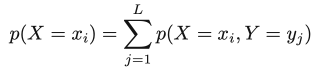

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , { \cal Y } = y _ { j } ) \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; Z = y _ { j = 1 } , { \cal Y } = y _ { j } ) \; \; \; \; \; \; \; \; \; \; \; \; \; \; p ( X = x _ { i } , { \cal Y } = y _ { j } ) \; \; \; \; \; \; p ( X = y ( X =


<IPython.core.display.Math object>

None


In [21]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

41 178 3
64
torch.Size([1, 64, 256])


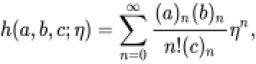

None


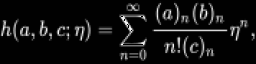

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty \infty \infty } \frac { ( a ) _ { n } } { n ! ( b ) _ { n } } { n ! ( c ) _ { n } } \eta } \eta } \eta } \eta } \eta } \eta ^ { \infty } \eta ^ { \infty } \eta ^ { ( c ) _ { n } } \eta } \eta } \eta } \eta } \eta } \eta } \eta <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [22]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

320 1080 3
106
torch.Size([1, 106, 360])


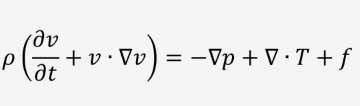

None


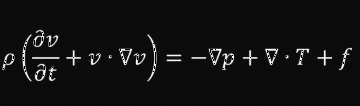

None

Predicted formula:
 <S> { \cal P } \left( \frac { \partial \psi } { \partial \xi } * { \bf \nabla } \psi \right) = - { \bf \nabla P } \times { \bf T } \cdot T * I } \right) _ { } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [23]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//3
w_new = w//3
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

None
64
torch.Size([1, 64, 128])


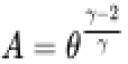

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } \gamma \nabla <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [24]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape
ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

384 812 3
192
torch.Size([1, 192, 406])


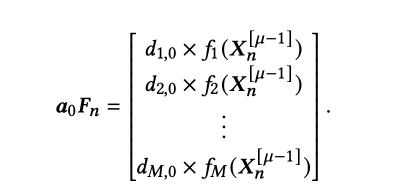

None


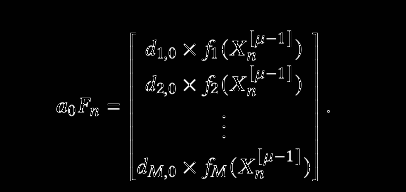

None

Predicted formula:
 <S> \begin{array} { l l l l l l l } { { \bf ~ } } & { \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displaystyle \displayst

<IPython.core.display.Math object>

None


In [25]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

200 1424 3
100
torch.Size([1, 100, 712])


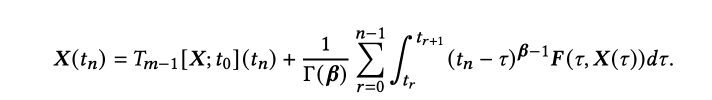

None

Predicted formula:
 <S> { \bf X ( t ) } = { \bf T } _ { \bf 0 } ( { \bf X } ) ( { \bf Z } ) * \frac { 1 } { \Gamma ( { \bf Z } ) } \sum _ { \cal E } \approx 0 } ^ { \bf q = 1 } { \bf f } _ { H } ^ { \bf t } ( { \bf f } _ { \bf p } - { \bf 7 } ) } { \bf F } ( { \bf q } ) } { \bf F } ( { \bf q } ( { \bf T } ) { \bf Z } { \bf r } . <E> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [26]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

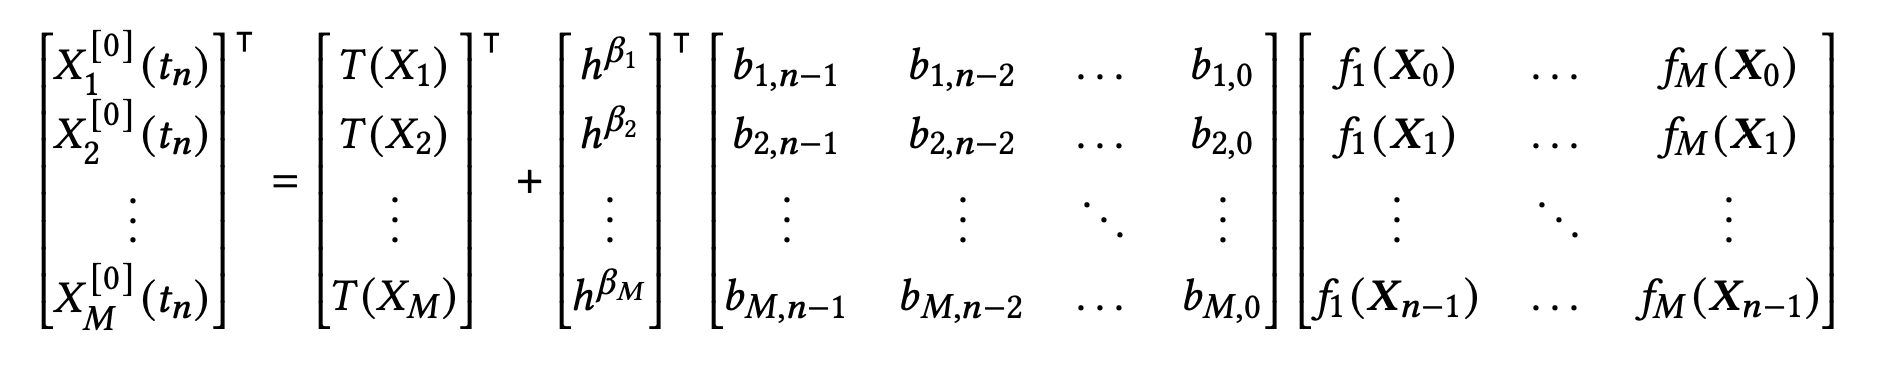

None
torch.Size([1, 392, 1904])


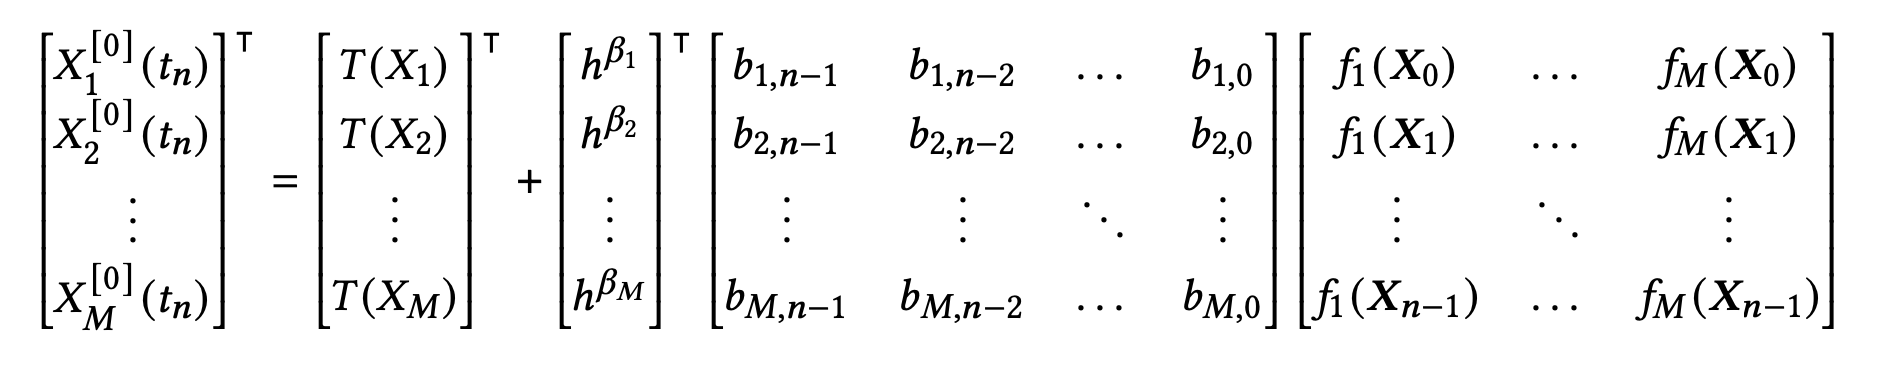

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c c c c c c c c c c c c c c c } { \bf L } \\ { 1 } & { } & { } & { } & { 1 } & { } & { 1 } & { } & { 1 } & { } & { 1 } & { 0 } \\ { 1 } & { 0 } & { 0 } & { 0 } & { 1 } & { 0 } & { 1 } & { 0 } \\ { 1 } & { 1 } & { 1 } & { } & { 1 } &


<IPython.core.display.Math object>

None


In [27]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_12.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

202 1774 3
torch.Size([1, 202, 1774])


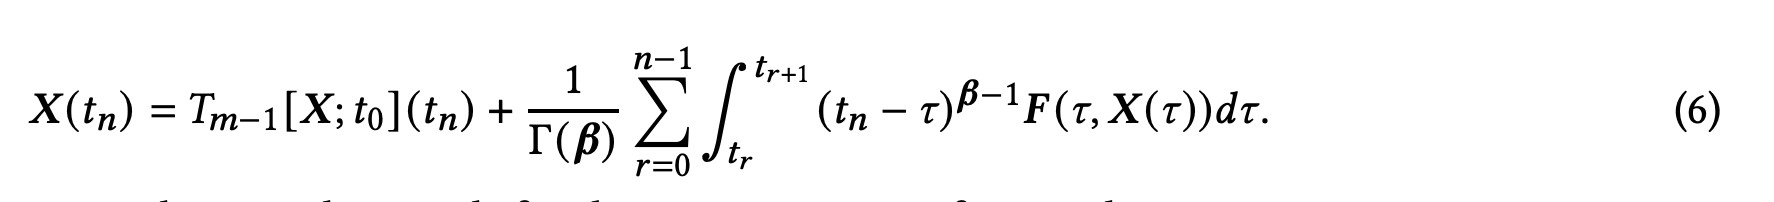

None


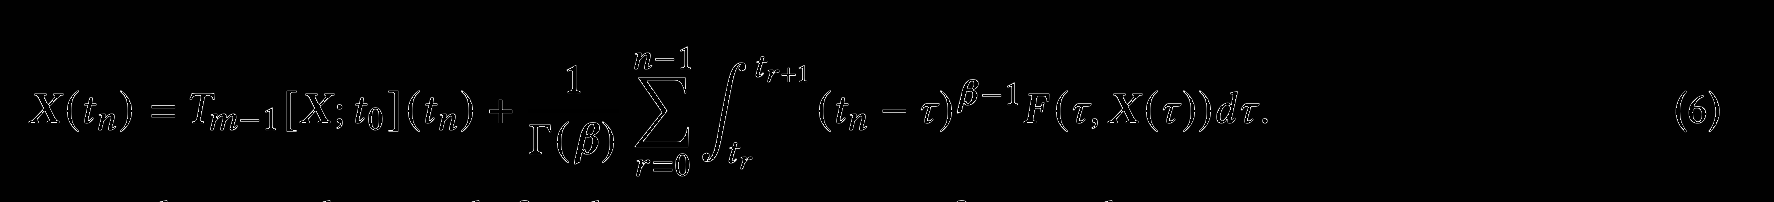

None

Predicted formula:
 <S> { \bf Z } { \bf L . } { \bf T _ { \bf Z . 1 } \leq } { \bf L . } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf 1 } { \bf L } { \bf L } { \bf Z } { \bf Z } { \bf Z } { \bf Z } { \bf { \bf { \bf {


<IPython.core.display.Math object>

None


In [28]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 64
#w_new = int(h_new*ratio)
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

188 1950 3
100
torch.Size([1, 100, 1000])


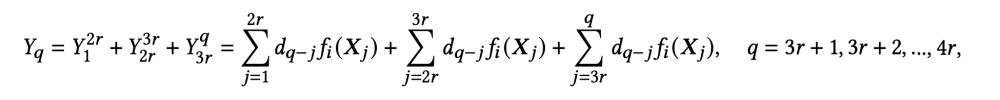

None


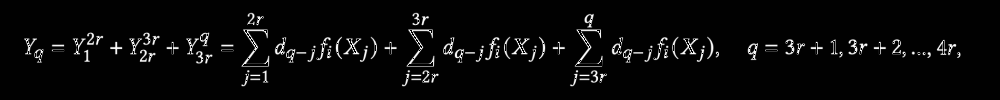

None

Predicted formula:
 <S> { \bf Y _ { 1 } ^ { 2 r } * Y _ { \bf r } ^ { 2 r } * Y _ { 2 r } ^ { q } \approx \sum _ { j = 1 } ^ { 2 { \cal F } } d _ { q - j f L } ( { \cal X } _ { j ) \star \sum _ { j \equiv 2 } ^ { 2 r } d q - f f f f ( { \cal X } j ) * \sum _ { j = 3 } ^ { 2 } d q - j f f L ( X _ { 2 } ) \quad q = 1 . <E> <P>


<IPython.core.display.Math object>

None


In [29]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 100
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

202 1774 3
torch.Size([1, 202, 1774])


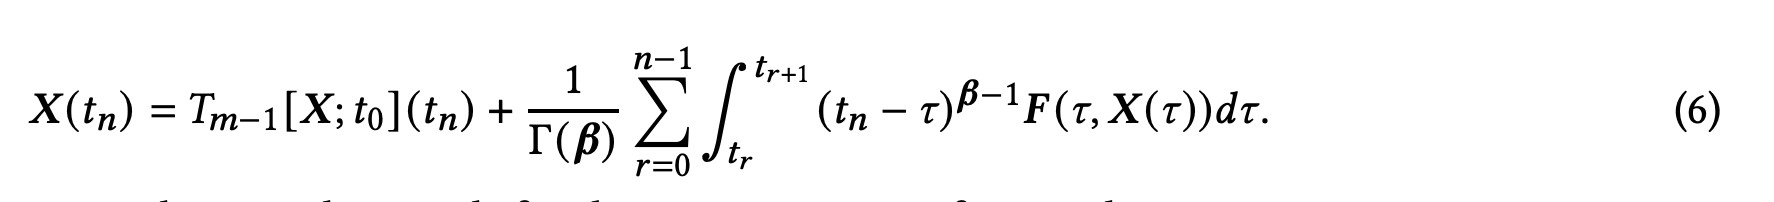

None

Predicted formula:
 <S> { \bf Z } { \bf L . } { \bf T _ { \bf Z . 1 } \leq } { \bf L . } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf L } { \bf 1 } { \bf L } { \bf L } { \bf Z } { \bf Z } { \bf Z } { \bf Z } { \bf { \bf { \bf {


<IPython.core.display.Math object>

None


In [30]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 100
#w_new = h_new*ratio
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
#c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(1774, 202)
(887, 101)


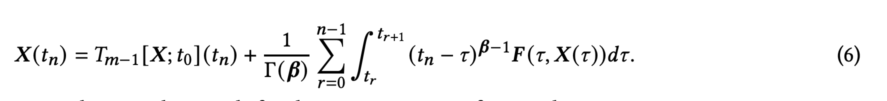

None


In [31]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image.size
print(image.size)
w_new = w//2
h_new = h//2
image = image.resize((w_new, h_new), resample=Image.Resampling.BILINEAR)
print(image.size)
print(display(image)) 


(202, 1774, 3)
(101, 887, 3)
torch.Size([1, 101, 887])


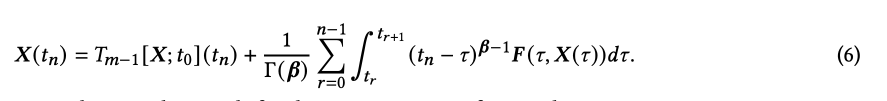

None


In [32]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5,interpolation=cv2.INTER_LINEAR)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

(23, 57, 3)
(69, 171, 3)
torch.Size([1, 69, 171])


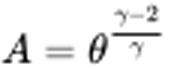

None


In [33]:
image_path= image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor)))

In [34]:
import torchvision

In [35]:
from torchvision import models
from torch import nn

In [36]:
resnet = models.resnet34(pretrained=False)

In [37]:
backbone1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
)

backbone2 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
    resnet.layer4
)

In [38]:
backbone1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [39]:
z = torch.zeros((4,8,3,5))
test = torch.ones((8,5,7))

In [40]:
res = z +test[:, :3, :5]

In [41]:
res.shape

torch.Size([4, 8, 3, 5])